#Region Based


In [1]:
from skimage.color import rgb2gray
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import ndimage
import numpy as np
import cv2
import matplotlib.pyplot as plt

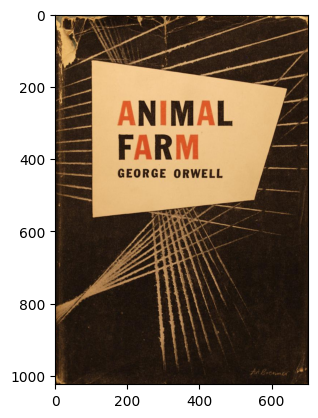

In [2]:
image = plt.imread('exemplo1.jpg')
image.shape
plt.imshow(image)

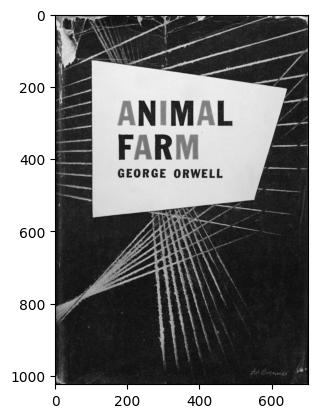

In [3]:
gray = rgb2gray(image)
plt.imshow(gray, cmap='gray')

In [4]:
gray.shape

(1024, 702)

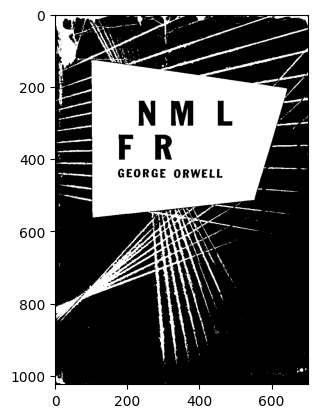

In [5]:
gray_r = gray.reshape(gray.shape[0]*gray.shape[1])
for i in range(gray_r.shape[0]):
    if gray_r[i] > gray_r.mean():
        gray_r[i] = 1
    else:
        gray_r[i] = 0
gray = gray_r.reshape(gray.shape[0],gray.shape[1])
plt.imshow(gray, cmap='gray')

#edge based


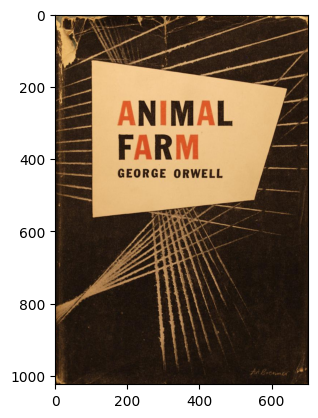

In [6]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import ndimage
from skimage.color import rgb2gray

image = plt.imread('exemplo1.jpg')
plt.imshow(image)

In [7]:
gray = rgb2gray(image)

sobel_horizontal = np.array([np.array([1, 2, 1]), np.array([0, 0, 0]), np.array([-1, -2, -1])])
sobel_vertical = np.array([np.array([-1, 0, 1]), np.array([-2, 0, 2]), np.array([-1, 0, 1])])

In [8]:
out_h = ndimage.convolve(gray, sobel_horizontal, mode='reflect')
out_v = ndimage.convolve(gray, sobel_vertical, mode='reflect')

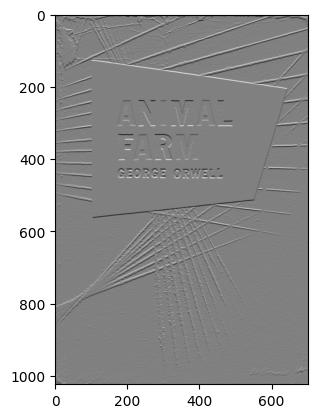

In [9]:
plt.imshow(out_h, cmap='gray')

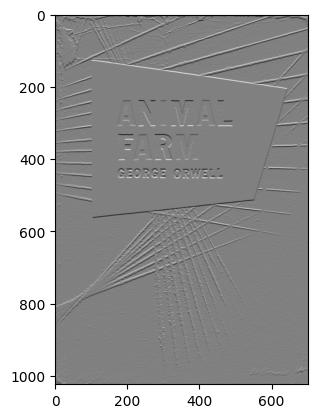

In [10]:
plt.imshow(out_h, cmap='gray')

#Clustering based


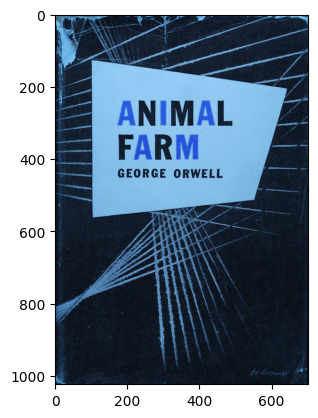

In [12]:
original_image = cv2.imread('exemplo1.jpg')
plt.imshow(original_image)

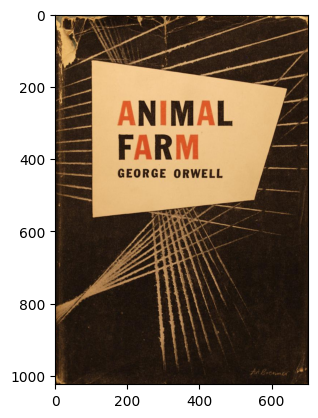

In [13]:
img = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [18]:
vectorized = img.reshape((-1,3))
vectorized = np.float32(vectorized)

In [25]:
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 2
attempts=10
ret,label,center=cv2.kmeans(vectorized,K,None,criteria,attempts,cv2.KMEANS_PP_CENTERS)

In [26]:
center = np.uint8(center)
res = center[label.flatten()]
result_image = res.reshape((img.shape))

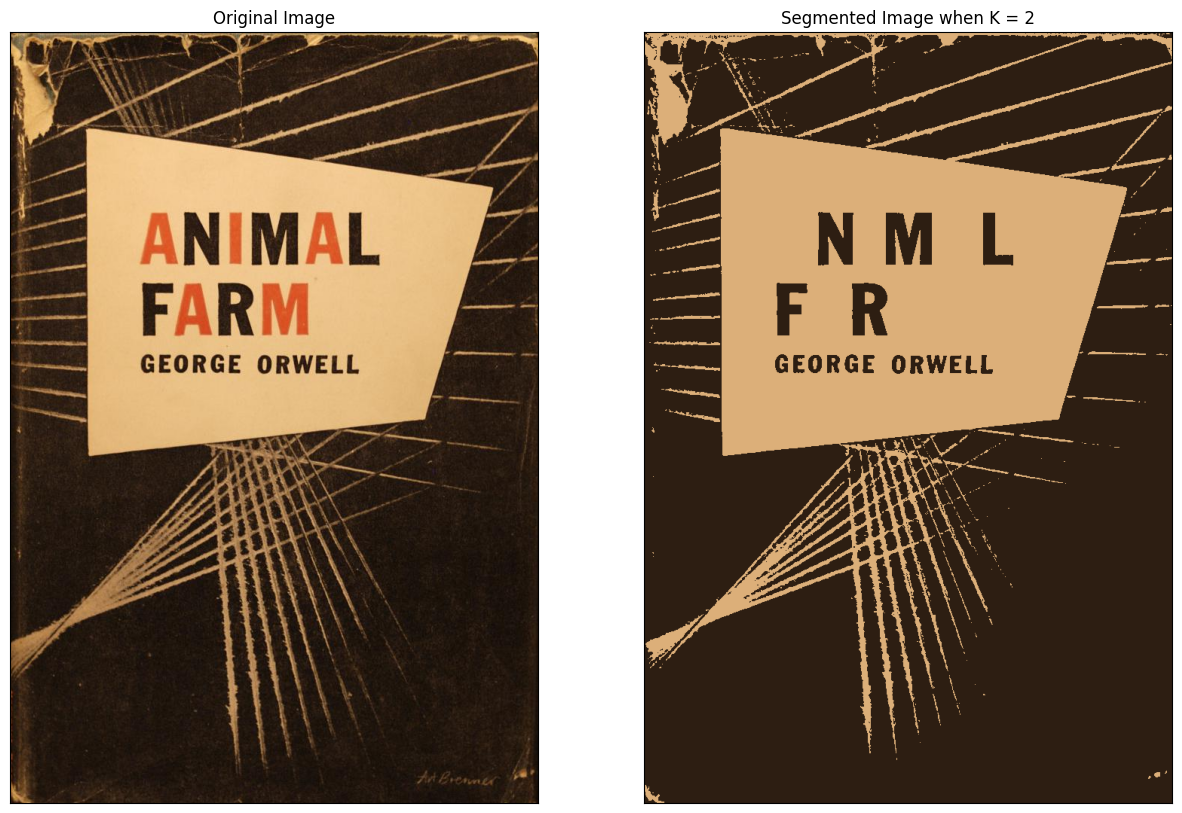

In [27]:
figure_size = 15
plt.figure(figsize=(figure_size,figure_size))
plt.subplot(1,2,1),plt.imshow(img)
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(1,2,2),plt.imshow(result_image)
plt.title('Segmented Image when K = %i' % K), plt.xticks([]), plt.yticks([])
plt.show()

#Distance Transform and Watershed Algorithm

In [28]:
from __future__ import print_function
import cv2 as cv
import numpy as np
import argparse
import random as rng

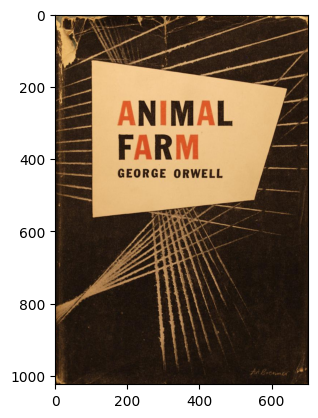

In [29]:
src = cv.imread('exemplo1.jpg')
img = cv.cvtColor(src, cv2.COLOR_BGR2RGB)
# Show source image
plt.imshow(img)
#plt.imshow('Source Image', src)

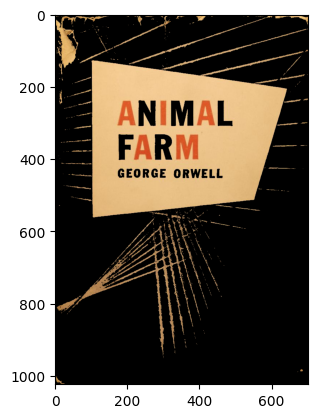

In [30]:
# Change the background from white to black, since that will help later to extract
# better results during the use of Distance Transform
img[np.all(img <= 160, axis=2)] = 0
# Show output image
plt.imshow(img)

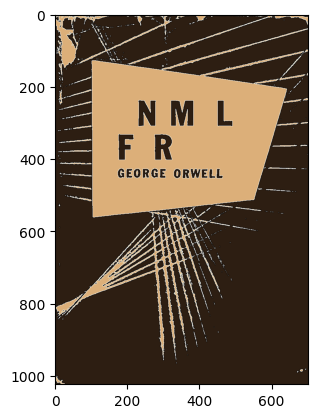

In [31]:
# Create a kernel that we will use to sharpen our image
# an approximation of second derivative, a quite strong kernel
kernel = np.array([[1, 1, 1], [1, -8, 1], [1, 1, 1]], dtype=np.float32)
# do the laplacian filtering as it is
# well, we need to convert everything in something more deeper then CV_8U
# because the kernel has some negative values,
# and we can expect in general to have a Laplacian image with negative values
# BUT a 8bits unsigned int (the one we are working with) can contain values from 0 to 255
# so the possible negative number will be truncated
imgLaplacian = cv.filter2D(result_image, cv.CV_32F, kernel)
sharp = np.float32(result_image)
imgResult = sharp - imgLaplacian
# convert back to 8bits gray scale
imgResult = np.clip(imgResult, 0, 255)
imgResult = imgResult.astype('uint8')
imgLaplacian = np.clip(imgLaplacian, 0, 255)
imgLaplacian = np.uint8(imgLaplacian)
#cv.imshow('Laplace Filtered Image', imgLaplacian)
plt.imshow(imgResult)

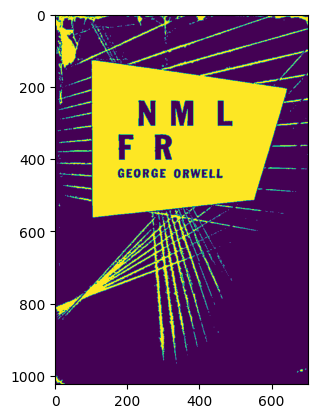

In [32]:
# Create binary image from source image
bw = cv.cvtColor(imgResult, cv.COLOR_BGR2GRAY)
_, bw = cv.threshold(bw, 40, 255, cv.THRESH_BINARY | cv.THRESH_OTSU)
plt.imshow(bw)


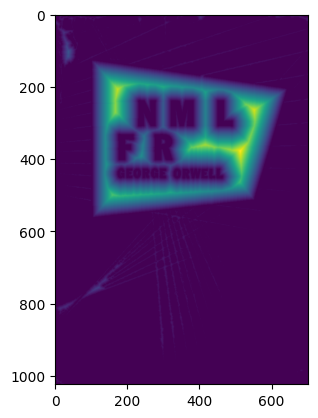

In [33]:
# Perform the distance transform algorithm
dist = cv.distanceTransform(bw, cv.DIST_L2, 3)
# Normalize the distance image for range = {0.0, 1.0}
# so we can visualize and threshold it
cv.normalize(dist, dist, 0, 1.0, cv.NORM_MINMAX)
plt.imshow( dist)

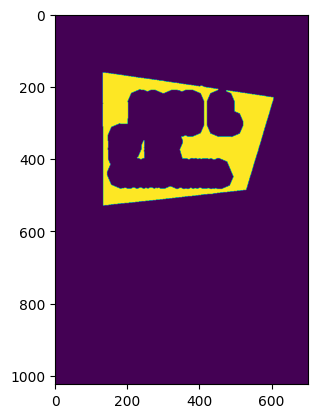

In [34]:
# Threshold to obtain the peaks
# This will be the markers for the foreground objects
_, dist = cv.threshold(dist, 0.4, 1.0, cv.THRESH_BINARY)
# Dilate a bit the dist image
kernel1 = np.ones((3,3), dtype=np.uint8)
dist = cv.dilate(dist, kernel1)
plt.imshow( dist)


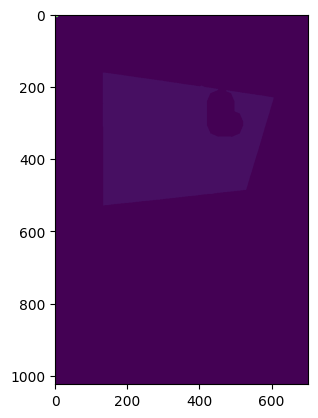

In [35]:
# Create the CV_8U version of the distance image
# It is needed for findContours()
dist_8u = dist.astype('uint8')
# Find total markers
contours, _ = cv.findContours(dist_8u, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
# Create the marker image for the watershed algorithm
markers = np.zeros(dist.shape, dtype=np.int32)
# Draw the foreground markers
for i in range(len(contours)):
    cv.drawContours(markers, contours, i, (i+1), -1)
# Draw the background marker
cv.circle(markers, (5,5), 3, (255,255,255), -1)
markers_8u = (markers * 10).astype('uint8')
plt.imshow( markers_8u)

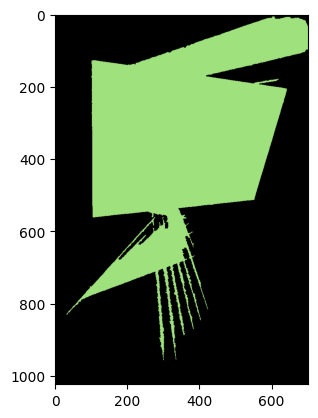

In [36]:
# Perform the watershed algorithm
cv.watershed(imgResult, markers)
#mark = np.zeros(markers.shape, dtype=np.uint8)
mark = markers.astype('uint8')
mark = cv.bitwise_not(mark)
# uncomment this if you want to see how the mark
# image looks like at that point
#cv.imshow('Markers_v2', mark)
# Generate random colors
colors = []
for contour in contours:
    colors.append((rng.randint(0,256), rng.randint(0,256), rng.randint(0,256)))
# Create the result image
dst = np.zeros((markers.shape[0], markers.shape[1], 3), dtype=np.uint8)
# Fill labeled objects with random colors
for i in range(markers.shape[0]):
    for j in range(markers.shape[1]):
        index = markers[i,j]
        if index > 0 and index <= len(contours):
            dst[i,j,:] = colors[index-1]
# Visualize the final image
plt.imshow( dst)

#mask r-cnn

#Texture segmentation with sklearn

In [37]:
pip install scikit-image

In [38]:
from skimage import data
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import skimage.data as data
import skimage.segmentation as seg
import skimage.filters as filters
import skimage.draw as draw
import skimage.color as color
from skimage import data
import numpy as np
import matplotlib.pyplot as plt

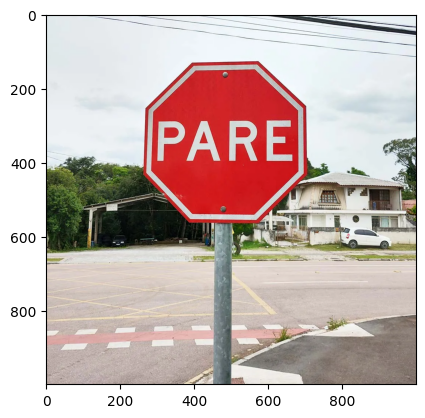

In [40]:
# The I/O module is used for importing the image
from skimage import data
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
image = io.imread('exemplo2.webp')
plt.imshow(image);

In [41]:
def image_show(image, nrows=1, ncols=1, cmap='gray'):
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 14))
    ax.imshow(image, cmap='gray')
    ax.axis('off')
    return fig, ax

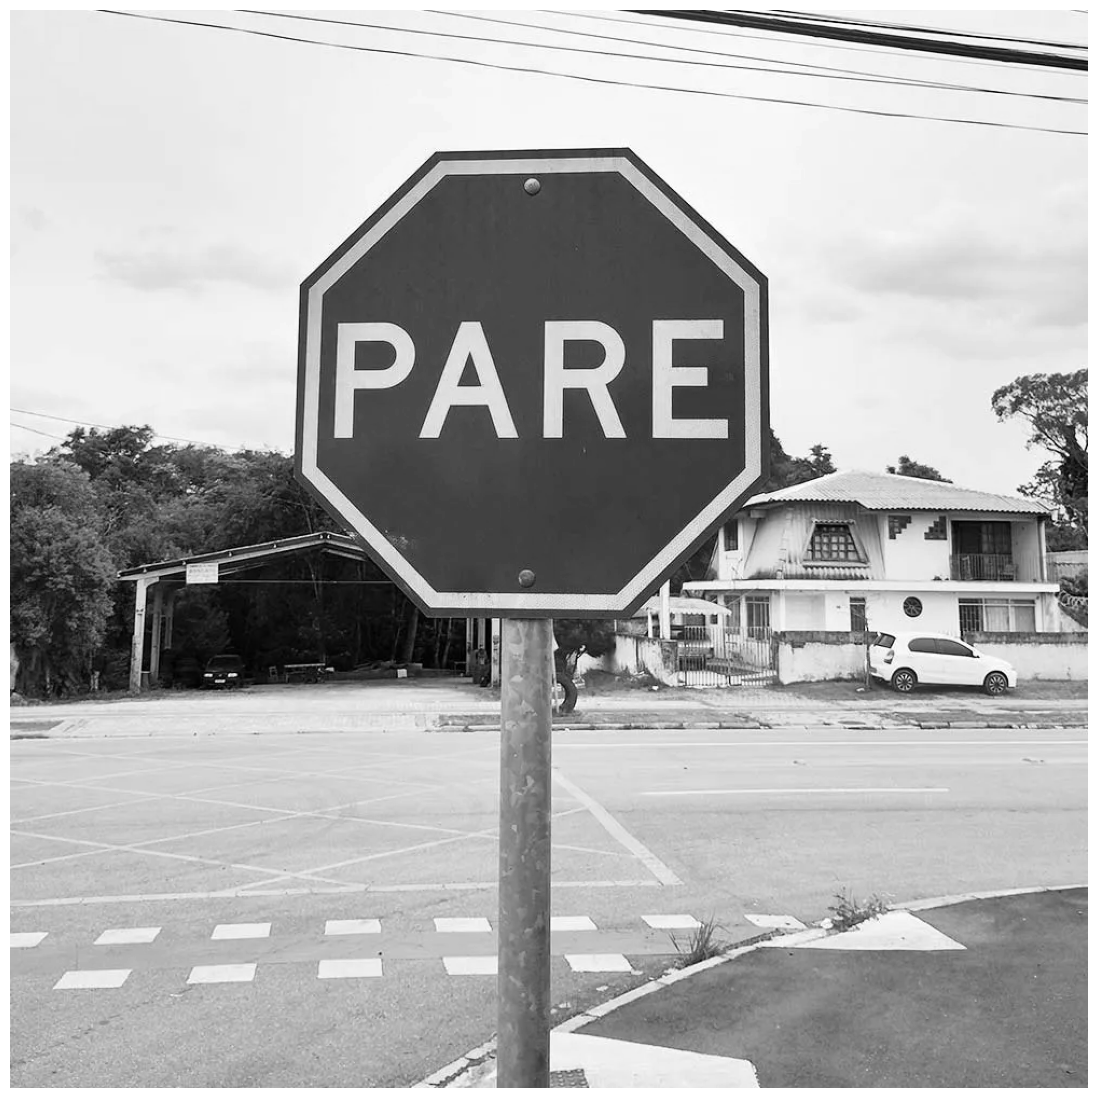

In [42]:
image_gray = color.rgb2gray(image)
image_show(image_gray);

In [64]:
def circle_points(resolution, center, radius):
    """
    Generate points which define a circle on an image.Centre refers to the centre of the circle
    """
    radians = np.linspace(0, 2*np.pi, resolution)
    c = center[1] + radius*np.cos(radians)#polar co-ordinates
    r = center[0] + radius*np.sin(radians)

    return np.array([c, r]).T
# Exclude last point because a closed path should not have duplicate points
points = circle_points(100, [350, 480], 230)[:-1]

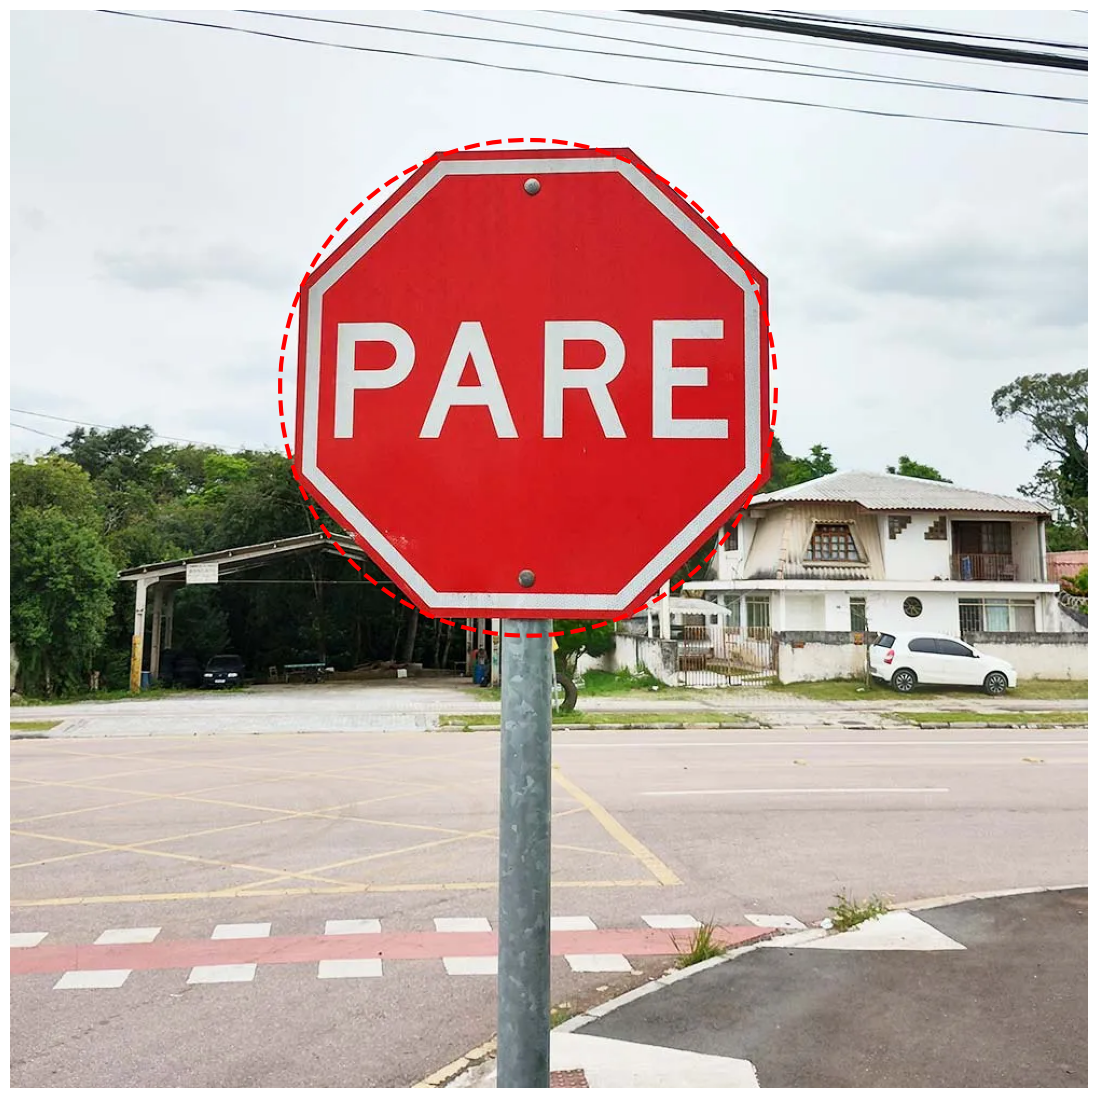

In [65]:
fig, ax = image_show(image)
ax.plot(points[:, 0], points[:, 1], '--r', lw=3)

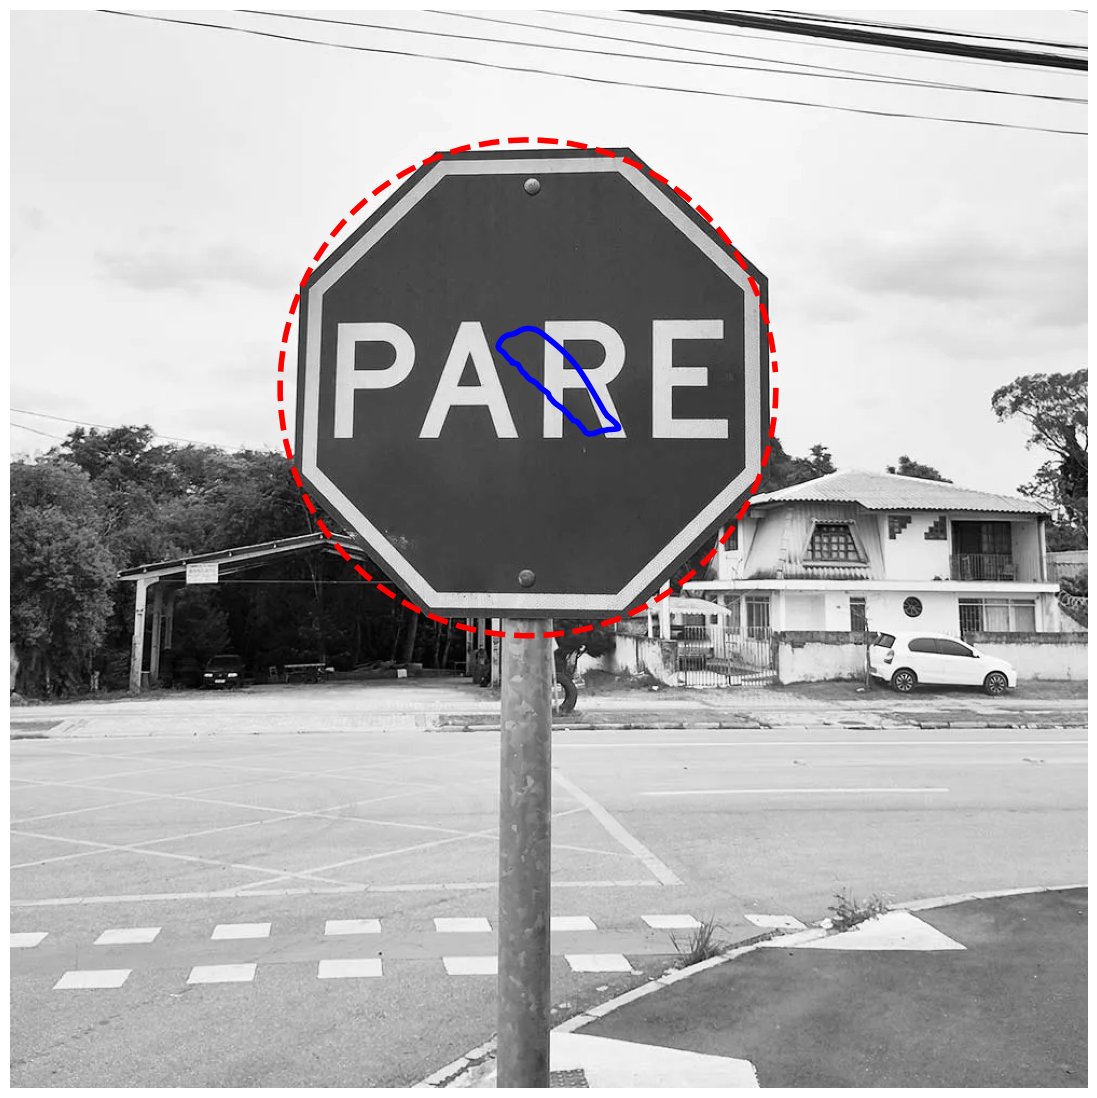

In [75]:
snake = seg.active_contour(image_gray, points,alpha=0.07,beta=0.5)
fig, ax = image_show(image_gray)
ax.plot(points[:, 0], points[:, 1], '--r', lw=4)
ax.plot(snake[:, 0], snake[:, 1], '-b', lw=4);

In [106]:
image_labels = np.zeros(image_gray.shape, dtype=np.uint8)

<ipython-input-107-1413e738f53c>:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  image_labels[points[:, 1].astype(np.int), points[:, 0].astype(np.int)] = 2


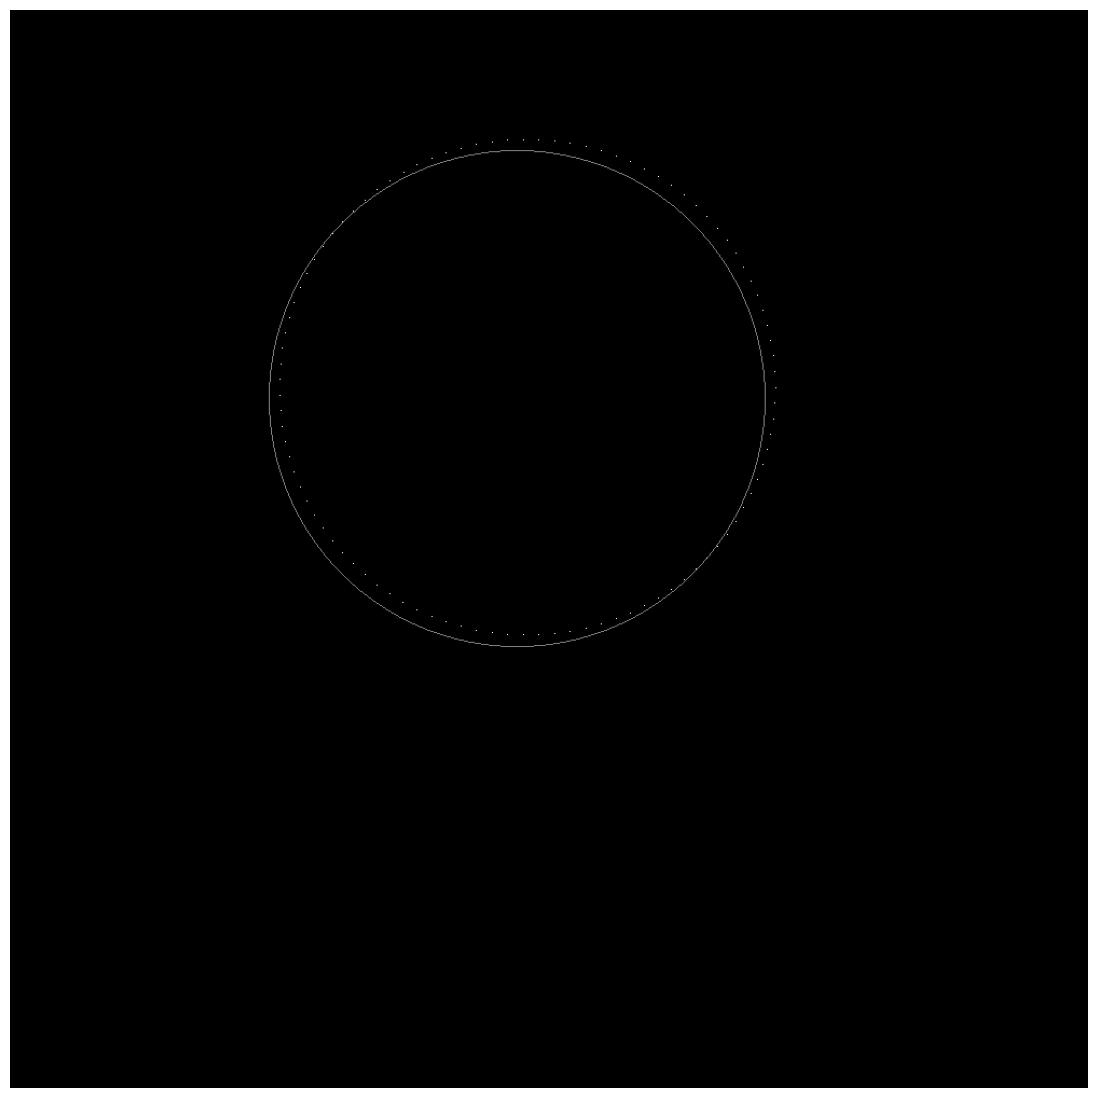

In [107]:
indices = draw.circle_perimeter(360, 470,230)#from here
image_labels[indices] = 1
image_labels[points[:, 1].astype(np.int), points[:, 0].astype(np.int)] = 2
image_show(image_labels);

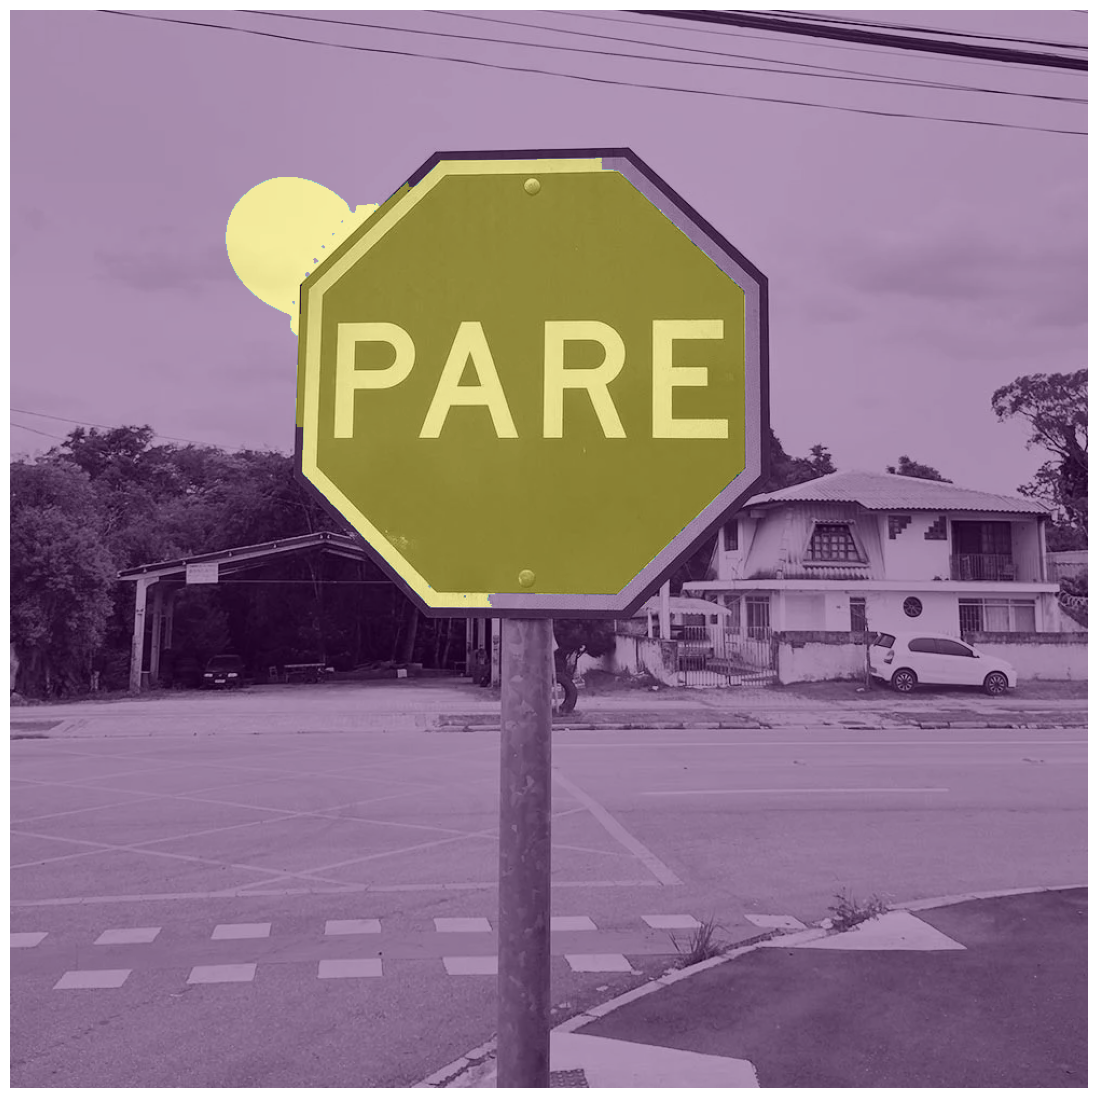

In [108]:
# Check our results
fig, ax = image_show(image_gray)
ax.imshow(image_segmented == 1, alpha=0.4);

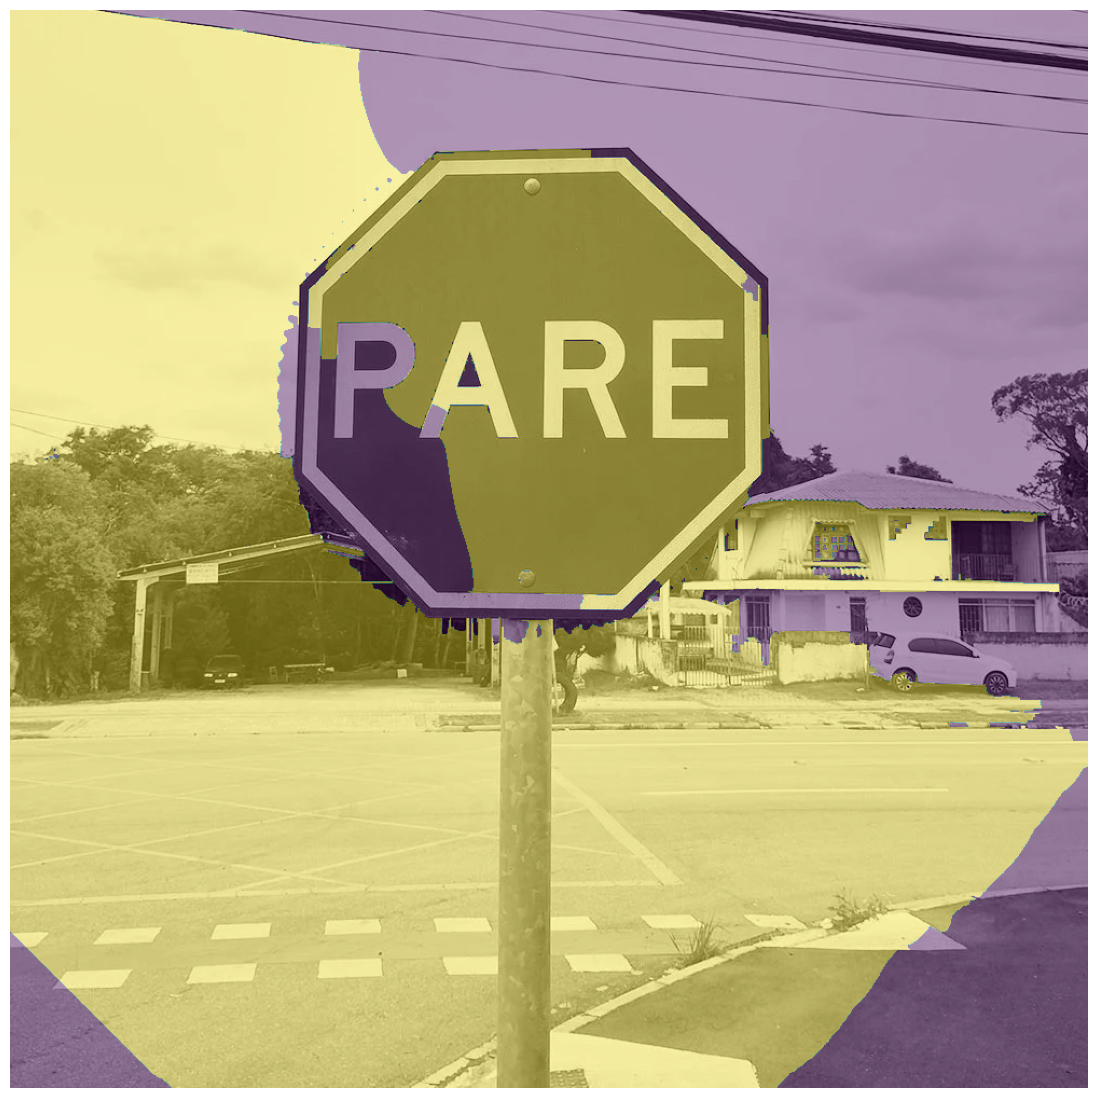

In [109]:
image_segmented = seg.random_walker(image_gray, image_labels, beta = 3000)
# Check our results
fig, ax = image_show(image_gray)
ax.imshow(image_segmented == 1, alpha=0.4);